<a href="https://colab.research.google.com/github/GMvandeVen/continual-learning/blob/master/hands_on_tutorial_InvictaSpringSchool.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Hands-on tutorial: Continual Learning

**You can make your own copy of this notebook by selecting File->Save a copy in Drive from the menu bar above.**

This Colab Notebook was originally used for a hands-on tutorial at the [INVICTA Spring School](https://invicta.inesctec.pt/) in March 2024. The estimated time for this tutorial is 2 hours. At the school, this hands-on tutorial was preceded by a 3-hour interactive lecutre, for which the slides can be found [here](https://gmvandeven.github.io/files/slides/InvictaSpringSchool_Mar2024.pdf).

Things you'll learn in this session:
- How to set up a simple continual learning experiment
- How to implement EWC, replay and EWC+replay
- How to evaluate and visualize the results of a continual learning experiment

This tutorial is based on code from this repository: https://github.com/GMvandeVen/continual-learning.

Other popular libraries for continual learning are [Avalanche](https://github.com/ContinualAI/avalanche) and [Mammoth](https://github.com/aimagelab/mammoth).

## Setup

### Load required libraries
First, let's load some packages that we are going to need. We use [PyTorch](https://pytorch.org/) as our main deep learning library.

In [ ]:
# Standard libraries
import numpy as np
import copy
import tqdm
# Pytorch
import torch
from torch.nn import functional as F
from torchvision import datasets, transforms
# For visualization
from torchvision.utils import make_grid
import matplotlib.pyplot as plt

### Download data
For this tutorial we will use the [MNIST dataset](http://yann.lecun.com/exdb/mnist/), to construct different types of conitnual learning experiments.

In [ ]:
MNIST_trainset = datasets.MNIST(root='data/', train=True, download=True,
                                transform=transforms.ToTensor())
MNIST_testset = datasets.MNIST(root='data/', train=False, download=True,
                               transform=transforms.ToTensor())
config = {'size': 28, 'channels': 1, 'classes': 10}

In [ ]:
#@title Visualization functions
def multi_context_barplot(axis, accs, title=None):
    '''Generate barplot using the values in [accs].'''
    contexts = len(accs)
    axis.bar(range(contexts), accs, color='k')
    axis.set_ylabel('Testing Accuracy (%)')
    axis.set_xticks(range(contexts), [f'Context {i+1}' for i in range(contexts)])
    if title is not None:
        axis.set_title(title)

def plot_examples(axis, dataset, context_id=None):
    '''Plot 25 examples from [dataset].'''
    data_loader = torch.utils.data.DataLoader(dataset, batch_size=25, shuffle=True)
    image_tensor, _ = next(iter(data_loader))
    image_grid = make_grid(image_tensor, nrow=5, pad_value=1) # pad_value=0 would give black borders
    axis.imshow(np.transpose(image_grid.numpy(), (1,2,0)))
    if context_id is not None:
        axis.set_title("Context {}".format(context_id+1))
    axis.axis('off')

## Part 1: Catastrophic forgetting - Permuted MNIST
Let's start by trying to set up a simple continual learning experiment, to check whether there is indeed catastrophic forgetting.

### Set up the benchmark (Permuted MNIST)
For this we will use "Permuted MNIST". In this continual learning experiment, in each context (or task), the neural network must learn to classify the ten MNIST digits. However, in each context a different permutation is applied to the pixels of all images.

Permuted MNIST was first used in this paper: https://arxiv.org/abs/1312.6211.

Let's start by specifying a function and a dataset class that we will use to create the various contexts (or tasks) of Permuted MNIST.

In [ ]:
# Function to apply a given permutation the pixels of an image.
def permutate_image_pixels(image, permutation):
    '''Permutate the pixels of [image] according to [permutation].'''

    if permutation is None:
        return image
    else:
        c, h, w = image.size()
        image = image.view(c, -1)
        image = image[:, permutation]  #--> same permutation for each channel
        image = image.view(c, h, w)
        return image

In [ ]:
# Class to create a dataset with images that have all been transformed in the same way.
class TransformedDataset(torch.utils.data.Dataset):
    '''To modify an existing dataset with a transform.
    Useful for creating different permutations of MNIST without loading the data multiple times.'''

    def __init__(self, original_dataset, transform=None, target_transform=None):
        super().__init__()
        self.dataset = original_dataset
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, index):
        (input, target) = self.dataset[index]
        if self.transform:
            input = self.transform(input)
        if self.target_transform:
            target = self.target_transform(target)
        return (input, target)

Now let's use these tools to create a Permuted MNIST benchmark with 2 contexts.

In [ ]:
contexts = 2

In [ ]:
# Specify for each context the permutations to use (with no permutation for the first context)
permutations = [None] + [np.random.permutation(config['size']**2) for _ in range(contexts-1)]

In [ ]:
# Specify for each context the transformed train- and testset
train_datasets = []
test_datasets = []
for context_id, perm in enumerate(permutations):
    train_datasets.append(TransformedDataset(
        MNIST_trainset, transform=transforms.Lambda(lambda x, p=perm: permutate_image_pixels(x, p)),
    ))
    test_datasets.append(TransformedDataset(
        MNIST_testset, transform=transforms.Lambda(lambda x, p=perm: permutate_image_pixels(x, p)),
    ))

In [ ]:
# Visualize the contexts
figure, axis = plt.subplots(1, contexts, figsize=(3*contexts, 4))

for context_id in range(len(train_datasets)):
    plot_examples(axis[context_id], train_datasets[context_id], context_id=context_id)

### Set up the model
Now it is time to define the neural network model that we will sequentially train on these two contexts.

We start by specifying some "helper functions" and "helper code" that make it easier to specify the model. If you are interested you can have a look at the code in the cell below, but that is not needed to follow the rest of this tutorial.

**It is however needed to run the code in the below cell!**

In [ ]:
#@title Helper functions

class Identity(torch.nn.Module):
    '''A nn-module to simply pass on the input data.'''
    def forward(self, x):
        return x

    def __repr__(self):
        tmpstr = self.__class__.__name__ + '()'
        return tmpstr


class Flatten(torch.nn.Module):
    '''A nn-module to flatten a multi-dimensional tensor to 2-dim tensor.'''
    def forward(self, x):
        batch_size = x.size(0)   # first dimenstion should be batch-dimension.
        return x.view(batch_size, -1)

    def __repr__(self):
        tmpstr = self.__class__.__name__ + '()'
        return tmpstr


class fc_layer(torch.nn.Module):
    '''Fully connected layer, with possibility of returning "pre-activations".

    Input:  [batch_size] x ... x [in_size] tensor
    Output: [batch_size] x ... x [out_size] tensor'''

    def __init__(self, in_size, out_size, nl=torch.nn.ReLU(), bias=True):
        super().__init__()
        self.bias = bias
        self.linear = torch.nn.Linear(in_size, out_size, bias=bias)
        if isinstance(nl, torch.nn.Module):
            self.nl = nl
        elif nl=="relu":
            self.nl = torch.nn.ReLU()
        elif nl=="leakyrelu":
          self.nl = torch.nn.LeakyReLU()

    def forward(self, x):
        pre_activ = self.linear(x)
        output = self.nl(pre_activ) if hasattr(self, 'nl') else pre_activ
        return output


class MLP(torch.nn.Module):
    '''Module for a multi-layer perceptron (MLP).

    Input:  [batch_size] x ... x [size_per_layer[0]] tensor
    Output: (tuple of) [batch_size] x ... x [size_per_layer[-1]] tensor'''

    def __init__(self, input_size=1000, output_size=10, layers=2,
                 hid_size=1000, hid_smooth=None, size_per_layer=None,
                 nl="relu", bias=True, output='normal'):
        '''sizes: 0th=[input], 1st=[hid_size], ..., 1st-to-last=[hid_smooth], last=[output].
        [input_size]       # of inputs
        [output_size]      # of units in final layer
        [layers]           # of layers
        [hid_size]         # of units in each hidden layer
        [hid_smooth]       if None, all hidden layers have [hid_size] units, else # of units linearly in-/decreases s.t.
                             final hidden layer has [hid_smooth] units (if only 1 hidden layer, it has [hid_size] units)
        [size_per_layer]   None or <list> with for each layer number of units (1st element = number of inputs)
                                --> overwrites [input_size], [output_size], [layers], [hid_size] and [hid_smooth]
        [nl]               <str>; type of non-linearity to be used (options: "relu", "leakyrelu", "none")
        [output]           <str>; if - "normal", final layer is same as all others
                                     - "none", final layer has no non-linearity
                                     - "sigmoid", final layer has sigmoid non-linearity'''

        super().__init__()
        self.output = output

        # get sizes of all layers
        if size_per_layer is None:
            hidden_sizes = []
            if layers > 1:
                if (hid_smooth is not None):
                    hidden_sizes = [int(x) for x in np.linspace(hid_size, hid_smooth, num=layers-1)]
                else:
                    hidden_sizes = [int(x) for x in np.repeat(hid_size, layers - 1)]
            size_per_layer = [input_size] + hidden_sizes + [output_size] if layers>0 else [input_size]
        self.layers = len(size_per_layer)-1

        # set label for this module
        # -determine "non-default options"-label
        nd_label = "{bias}{nl}".format(
            bias="" if bias else "n",
            nl="l" if nl=="leakyrelu" else ("n" if nl=="none" else ""),
        )
        nd_label = "{}{}".format("" if nd_label=="" else "-{}".format(nd_label),
                                 "" if output=="normal" else "-{}".format(output))
        # -set label
        size_statement = ""
        for i in size_per_layer:
            size_statement += "{}{}".format("-" if size_statement=="" else "x", i)
        self.label = "F{}{}".format(size_statement, nd_label) if self.layers>0 else ""

        # set layers
        for lay_id in range(1, self.layers+1):
            # number of units of this layer's input and output
            in_size = size_per_layer[lay_id-1]
            out_size = size_per_layer[lay_id]
            # define and set the fully connected layer
            layer = fc_layer(
                in_size, out_size, bias=bias,
                nl=("none" if output=="none" else nn.Sigmoid()) if (
                    lay_id==self.layers and not output=="normal"
                ) else nl,
            )
            setattr(self, 'fcLayer{}'.format(lay_id), layer)

        # if no layers, add "identity"-module to indicate in this module's representation nothing happens
        if self.layers<1:
            self.noLayers = Identity()

    def forward(self, x):
        for lay_id in range(1, self.layers + 1):
            x = getattr(self, "fcLayer{}".format(lay_id))(x)
        return x

    @property
    def name(self):
        return self.label

Now let's specify a class for a basic neural network classifier model.

In [ ]:
class Classifier(torch.nn.Module):
    '''Model for classifying images.'''

    def __init__(self, image_size, image_channels, output_units,
                 fc_layers=3, fc_units=1000, fc_nl="relu", bias=True):

        super().__init__()

       # Flatten image to 2D-tensor
        self.flatten = Flatten()

        # Specify the fully connected hidden layers
        input_size = image_channels * image_size * image_size
        self.fcE = MLP(input_size=input_size, output_size=fc_units, layers=fc_layers-1,
                       hid_size=fc_units, nl=fc_nl, bias=bias)
        mlp_output_size = fc_units if fc_layers>1 else self.input_size

        # Specify the final linear classifier layer
        self.classifier = fc_layer(mlp_output_size, output_units, nl='none')

    def forward(self, x):
        flatten_x = self.flatten(x)
        final_features = self.fcE(flatten_x)
        out = self.classifier(final_features)
        return out

Let's create an instance of such a classifier model, and print some details of it to screen.

In [ ]:
# Specify the architectural layout of the network to use
fc_lay = 4        #--> number of fully-connected layers
fc_units = 40     #--> number of units in each hidden layer
fc_nl = "relu"    #--> what non-linearity to use?

In [ ]:
# Define the model
model = Classifier(image_size=config['size'], image_channels=config['channels'],
                   output_units=config['classes'],
                   fc_layers=fc_lay, fc_units=fc_units, fc_nl=fc_nl)

In [ ]:
# Print the network architecture
model

In [ ]:
# Print info regarding number of parameters
total_params = 0
for param in model.parameters():
    n_params = index_dims = 0
    for dim in param.size():
        n_params = dim if index_dims==0 else n_params*dim
        index_dims += 1
    total_params += n_params
print( "--> this network has {} parameters (~{}K)"
      .format(total_params, round(total_params / 1000)))

### Train on first context
It's time to start training the model on the first context (i.e., the regular MNIST dataset).

To do this, let's define a function to that can train a given neural network (i.e., `model`) on a particular dataset (i.e., `dataset`). We can then later re-use this function, for example to train the network on the dataset of the second context.

We can also specify the number of iterations we want to train for, the learning rate and the mini batch-size.

In [ ]:
def train(model, dataset, iters, lr, batch_size):
    # Define the optimizer
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, betas=(0.9, 0.999))

    # Set model in training-mode
    model.train()

    # Initialize # iters left on current data-loader(s)
    iters_left = 1

    # Define tqdm progress bar(s)
    progress_bar = tqdm.tqdm(range(1, iters+1))

    # Loop over all iterations
    for batch_index in range(1, iters+1):

        # Update # iters left on current data-loader(s) and, if needed, create new one(s)
        iters_left -= 1
        if iters_left==0:
            data_loader = iter(torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                                          shuffle=True, drop_last=True))
            iters_left = len(data_loader)

        # Sample training data of current context
        x, y = next(data_loader)

        # Reset optimizer
        optimizer.zero_grad()

        # Run model
        y_hat = model(x)

        # Calculate prediction loss
        loss = torch.nn.functional.cross_entropy(input=y_hat, target=y, reduction='mean')

        # Calculate training-accuracy (in %)
        accuracy = (y == y_hat.max(1)[1]).sum().item()*100 / x.size(0)

        # Backpropagate errors
        loss.backward()

        # Take the optimizer step
        optimizer.step()

        # Update progress bar
        progress_bar.set_description(
        '<CLASSIFIER> | training loss: {loss:.3} | training accuracy: {prec:.3}% |'
            .format(loss=loss.item(), prec=accuracy)
        )
        progress_bar.update(1)

    # Close the progress bar
    progress_bar.close()

Now we need to choose the training hyperparameters (i.e., learning rate, batch size and number of iterations).

In [ ]:
iters = 200       # for how many iterations to train?
lr = 0.01         # learning rate
batch_size = 128  # size of mini-batches

And let's train our neural network on the first context.

In [ ]:
# Train the model on the first context
train(model, dataset=train_datasets[0], iters=iters, lr=lr, batch_size=batch_size)

#### Evaluate
Did the training work? Let's find out by evaluating the performance of the trained model on the MNIST test set.

Again, let's start by specifying a function to evaluate any given model (i.e., `model`) on a specific dataset (i.e., `dataset`).

In [ ]:
def test_acc(model, dataset, test_size=None, batch_size=128):
    '''Evaluate accuracy (% samples classified correctly) of a classifier ([model]) on [dataset].'''

    # Set model to eval()-mode
    mode = model.training
    model.eval()

    # Loop over batches in [dataset]
    data_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                              shuffle=True, drop_last=False)
    total_tested = total_correct = 0
    for x, y in data_loader:
        # -break on [test_size] (if "None", full dataset is used)
        if test_size:
            if total_tested >= test_size:
                break
        # -evaluate model
        with torch.no_grad():
            scores = model(x)
        _, predicted = torch.max(scores, 1)
        # -update statistics
        total_correct += (predicted == y).sum().item()
        total_tested += len(x)
    accuracy = total_correct*100 / total_tested

    # Set model back to its initial mode, print result on screen (if requested) and return it
    model.train(mode=mode)

    return accuracy

Now let's use this function to evaluate the performance of the model on both the test data from context 1 (i.e., regular MNIST, on which the model was just trained) and on the test data from context 2 (i.e., a permuted version of MNIST, on which the model has not yet been trained).

In [ ]:
# Evaluate accuracy per context and print to screen
print("\n Accuracy (in %) of the model on test-set of:")
context1_accs = []
for i in range(contexts):
    acc = test_acc(model, test_datasets[i], test_size=None)
    print(" - Context {}: {:.1f}".format(i+1, acc))
    context1_accs.append(acc)

The model does well on test data from context 1, but is around chance level for test data from context 2.

This is not very surprising, as we have not yet trained the model on context 2!

#### Store model copy (for later)
Before continuing to train the model on the second context, let's store a copy of the model after training on the first context. We will later use this model copy to try out different ways of training the same model on the second context (i.e., we will try out different continual learning methods).

In [ ]:
model_after_context1 = copy.deepcopy(model)

### Train on second context
Now let's continue to train our model on the second context, and see what happens.

In [ ]:
# Continue to train the model on the second context
train(model, dataset=train_datasets[1], iters=iters, lr=lr, batch_size=batch_size)

#### Evaluate

In [ ]:
# Evaluate accuracy per context and print to screen
print("\n Accuracy (in %) of the model on test-set of:")
context2_accs = []
for i in range(contexts):
    acc = test_acc(model, test_datasets[i], test_size=None)
    print(" - Context {}: {:.1f}".format(i+1, acc))
    context2_accs.append(acc)

### Train on both contexts at the same time

In [ ]:
# Define a new model with same architecture
model_joint = Classifier(image_size=config['size'], image_channels=config['channels'],
                         output_units=config['classes'],
                         fc_layers=fc_lay, fc_units=fc_units, fc_nl=fc_nl)

In [ ]:
# Create a joint dataset with data from both contexts
joint_trainset = torch.utils.data.ConcatDataset(train_datasets)

We will use the same training-hyperparameters, except that we double the batch size.

In [ ]:
batch_size_joint = 256

In [ ]:
# Train the joint model
train(model_joint, dataset=joint_trainset, iters=iters, lr=lr, batch_size=batch_size_joint)

In [ ]:
# Evaluate the model
print("\n Accuracy (in %) of the model on test-set of:")
joint_accs = []
for i in range(contexts):
    acc = test_acc(model_joint, test_datasets[i], test_size=None)
    print(" - Context {}: {:.1f}".format(i+1, acc))
    joint_accs.append(acc)

### Visualize results

In [ ]:
# Visualize
figure, axis = plt.subplots(1, 4, figsize=(15, 5))

title='After training on context 1, \nbut not yet training on context 2'
multi_context_barplot(axis[0], context1_accs, title)

title='After first training on context 1, \nand then training on context 2'
multi_context_barplot(axis[1], context2_accs, title)

axis[2].axis('off')

title='After jointly training on both contexts'
multi_context_barplot(axis[3], joint_accs, title)

We have observed **catastrophic forgetting**! When our neural network model first learns context 1 and is then trained on context 2, the model's performance on data from context 1 substantially drops (left panels). When the same neural network model is instead trained on both context 1 and 2 at the same time, the model is able to learn both contexts well (right panel), demonstrating that the forgetting cannot be explained by limited model capacity.

## Part 2: Overcoming catastrophic forgetting - EWC & replay

Now that we found catastrophic forgetting, let's try out some methods to mitigate the forgetting.

We will start by exploring two methods: EWC and replay. For both methods, the training on the first context is the same as before. We can therefore use as starting point the copy of the model that we stored after finishing training on the first context.

In [ ]:
model_ewc = copy.deepcopy(model_after_context1)
model_replay = copy.deepcopy(model_after_context1)

#### Elastic Weight Consolidation (EWC)
EWC is a popular parameter regularization strategy for continual learning. It was introduced in the paper "[Overcoming catastrophic forgetting in neural networks
](https://www.pnas.org/doi/abs/10.1073/pnas.1611835114)" (Kirkpatrick et al., 2017; *PNAS*).

EWC computes a diagonal approximation to the [Fisher Information matrix]((https://en.wikipedia.org/wiki/Fisher_information) to estimate for each parameter of the network how important it is for the performance on the previous context. During training on the next context, these parameter importance estimates are then used to penalize changes to the parameters, with changes to the most important parameters penalized most.



When training on context $k>1$, the EWC regularization term is given by:
$$
\mathcal{L}^{(k)}_{\text{regularization}_{\text{EWC}}}\left(\boldsymbol{\theta}\right) = \frac{1}{2} \sum_{i=1}^{N_{\text{params}}} \tilde{F}_{ii}^{(k)} \left(\theta_i - \hat{\theta}_{i}^{(k)} \right)^2
$$
whereby $\hat{\theta}_{i}^{(k)}$ is the $i^{\text{th}}$ element of $\hat{\boldsymbol{\theta}}^{\left(k\right)}$, which is the vector with parameter values at the end of training of task $k$, and $\tilde{F}_{ii}^{(k)}$ is an approximation of $F_{ii}^{(k)}$, the $i^{\text{th}}$ diagonal element of $\boldsymbol{F}^{(k)}$, which is the Fisher Information matrix of task $k$ evaluated at $\hat{\boldsymbol{\theta}}^{(k)}$.

(Technically, the above regularization term is for `[Online EWC](https://arxiv.org/abs/1805.06370)'. The original version of EWC did something weird, as explained in [this blog post](https://www.inference.vc/comment-on-overcoming-catastrophic-forgetting-in-nns-are-multiple-penalties-needed-2/).)

The Fisher Information matrix is defined as the covariance of the `score', which is the partial derivative with respect to $\boldsymbol{\theta}$ of the natural logarithm of the likelihood function. The $i^{\text{th}}$ diagonal element of the Fisher Information on context $k$ is therefore given by:

$$
F_{ii}^{(k)} = \mathbb{E}_{\boldsymbol{x}\sim Q_{\boldsymbol{x}}^{(k)}} \left[ \ \mathbb{E}_{p_{\hat{\boldsymbol{\theta}}^{(k)}}} \left[ \left(  \left. \frac{\delta \log{p_{\boldsymbol{\theta}}\left(Y=y|\boldsymbol{x}\right)}}{\delta \theta_i} \right\rvert_{\boldsymbol{\theta}=\hat{\boldsymbol{\theta}}^{(k)}} \right)^2 \right] \right]
$$

whereby $Q_{\boldsymbol{x}}^{(k)}$ is the input distribution of context $k$, $p_{\boldsymbol{\theta}}$ is the conditional distribution of $y$ given $\boldsymbol{x}$ defined by the neural network with parameters $\boldsymbol{\theta}$, and $\hat{\boldsymbol{\theta}}^{(k)}$ is the vector with parameter values after finisihing training on context $k$.

The outer expectation in the above equation can be approximated using a random sample from the training set of context $k$. Because there is only a finit number of possible classes, the inner expectation in the above equation can be calculated for each sample exactly:
$$
\tilde{F}_{ii}^{(k)} = \frac{1}{|S^{(k)}|} \sum_{\boldsymbol{x}\in S^{(k)}} \left( \sum_{c=1}^{N_{\text{classes}}} \tilde{y}_c \left( \left. \frac{\delta\log p_{\boldsymbol{\theta}}\left(Y=c|\boldsymbol{x}\right)}{\delta\theta_i} \right\rvert_{\boldsymbol{\theta}=\hat{\boldsymbol{\theta}}^{(k)}} \right)^2 \right)
$$
whereby $S^{(k)}$ is the random sample of training data of context $k$ and $\tilde{y}_c = p_{\hat{\boldsymbol{\theta}}^{(k)}}\left(Y=c|\boldsymbol{x}\right)$ (i.e., the probability that input $\boldsymbol{x}$ belongs to class $c$ as predicted by the model after finishing training on context $k$).

**In the literature or on GitHub, often different, rather crude approximations of the Fisher Information are used ([example](https://github.com/ContinualAI/avalanche/blob/dbdc3804b11710b85b0e564b13034f487c7cf806/avalanche/training/plugins/ewc.py#L132-L186)). Be careful, as the quality of this approximation might influence the results!**

In [ ]:
def estimate_fisher(model, dataset, n_samples, ewc_gamma=1.):
    '''Estimate diagonal of Fisher Information matrix for [model] on [dataset] using [n_samples].'''

    # Prepare <dict> to store estimated Fisher Information matrix
    est_fisher_info = {}
    for n, p in model.named_parameters():
        n = n.replace('.', '__')
        est_fisher_info[n] = p.detach().clone().zero_()

    # Set model to evaluation mode
    mode = model.training
    model.eval()

    # Create data-loader to give batches of size 1
    data_loader = torch.utils.data.DataLoader(dataset, batch_size=1)

    # Estimate the FI-matrix for [n_samples] batches of size 1
    for index,(x,y) in enumerate(data_loader):
        # break from for-loop if max number of samples has been reached
        if n_samples is not None:
            if index > n_samples:
                break
        # run forward pass of model
        output = model(x)
        # calculate the FI-matrix
        with torch.no_grad():
            label_weights = F.softmax(output, dim=1)  #--> get weights, with no gradient tracked
        # - loop over all classes
        for label_index in range(output.shape[1]):
            label = torch.LongTensor([label_index])
            negloglikelihood = F.cross_entropy(output, label)
            # Calculate gradient of negative loglikelihood for this class
            model.zero_grad()
            negloglikelihood.backward(retain_graph=True if (label_index+1)<output.shape[1] else False)
            # Square gradients and keep running sum (using the weights)
            for n, p in model.named_parameters():
                n = n.replace('.', '__')
                if p.grad is not None:
                    est_fisher_info[n] += label_weights[0][label_index] * (p.grad.detach() ** 2)

    # Normalize by sample size used for estimation
    est_fisher_info = {n: p/index for n, p in est_fisher_info.items()}

    # Store new values in the network
    for n, p in model.named_parameters():
        n = n.replace('.', '__')
        # -mode (=MAP parameter estimate)
        model.register_buffer('{}_EWC_param_values'.format(n,), p.detach().clone())
        # -precision (approximated by diagonal Fisher Information matrix)
        if hasattr(model, '{}_EWC_estimated_fisher'.format(n)):
            existing_values = getattr(model, '{}_EWC_estimated_fisher'.format(n))
            est_fisher_info[n] += ewc_gamma * existing_values
        model.register_buffer('{}_EWC_estimated_fisher'.format(n), est_fisher_info[n])

    # Set model back to its initial mode
    model.train(mode=mode)

We need to define a new training function for EWC by adding the above regularization term to the loss.

In [ ]:
# (only the steps that differ from the original `train`-function are commented)
def train_ewc(model, dataset, iters, lr, batch_size, current_context, ewc_lambda=100.):
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, betas=(0.9, 0.999))
    model.train()
    iters_left = 1
    progress_bar = tqdm.tqdm(range(1, iters+1))

    for batch_index in range(1, iters+1):
        iters_left -= 1
        if iters_left==0:
            data_loader = iter(torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                                           shuffle=True, drop_last=True))
            iters_left = len(data_loader)
        x, y = next(data_loader)
        optimizer.zero_grad()
        y_hat = model(x)
        loss = torch.nn.functional.cross_entropy(input=y_hat, target=y, reduction='mean')

        # Compute the EWC-regularization term, and add it to the loss (except if first context)
        if current_context>1:
            ewc_losses = []
            for n, p in model.named_parameters():
                # Retrieve stored mode (MAP estimate) and precision (Fisher Information matrix)
                n = n.replace('.', '__')
                mean = getattr(model, '{}_EWC_param_values'.format(n))
                fisher = getattr(model, '{}_EWC_estimated_fisher'.format(n))
                # Calculate weight regularization loss
                ewc_losses.append((fisher * (p-mean)**2).sum())
            ewc_loss = (1./2)*sum(ewc_losses)
            total_loss = loss + ewc_lambda*ewc_loss
        else:
            total_loss = loss

        accuracy = (y == y_hat.max(1)[1]).sum().item()*100 / x.size(0)
        total_loss.backward()
        optimizer.step()
        progress_bar.set_description(
        '<CLASSIFIER> | training loss: {loss:.3} | training accuracy: {prec:.3}% |'
            .format(loss=total_loss.item(), prec=accuracy)
        )
        progress_bar.update(1)
    progress_bar.close()

Let's train the model on the second context using EWC.

In [ ]:
# Estimate the FI-matrix (and store it as attribute in the network)
estimate_fisher(model_ewc, train_datasets[0], n_samples=200)

In [ ]:
# Train on the second context using EWC parameter regularization
ewc_lambda = 100   #--> this is a "continual learning hyperparameter", setting these is a delicate
                   #    business. Here we ignore that and just use one that gives good performance.
train_ewc(model_ewc, train_datasets[1], iters=iters, lr=lr, batch_size=batch_size,
          current_context=2, ewc_lambda=ewc_lambda)

... and evaluate its performance.

In [ ]:
# Evaluate the model
print("\n Accuracy (in %) of the model on test-set of:")
ewc_accs = []
for i in range(contexts):
    acc = test_acc(model_ewc, test_datasets[i], test_size=None)
    print(" - Context {}: {:.1f}".format(i+1, acc))
    ewc_accs.append(acc)

That worked well! The performance on the first context barely dropped while the network learned the second context.

#### Experience Replay
For comparison, now let's train another model copy on the second context using 'experience replay'.

The typical approach is to store a relatively small amount of samples from previous contexts, and revisit those when training on a new context. We thus first need to populate a memory buffer with some samples from the first context. We select these samples using class-balanced random sampling from the training set (other approaches are possible here, how to optimally select the samples to store in the memory buffer is an active field of research).

In [ ]:
#@title Helper dataset classes for constructing memory buffer
class SubDataset(torch.utils.data.Dataset):
    '''To sub-sample a dataset, taking only those samples with label in [sub_labels].

    After this selection of samples has been made, it is possible to transform the target-labels,
    which can be useful when doing continual learning with fixed number of output units.'''

    def __init__(self, original_dataset, sub_labels, target_transform=None):
        super().__init__()
        self.dataset = original_dataset
        self.sub_indeces = []
        for index in range(len(self.dataset)):
            if hasattr(original_dataset, "targets"):
                if self.dataset.target_transform is None:
                    label = self.dataset.targets[index]
                else:
                    label = self.dataset.target_transform(self.dataset.targets[index])
            else:
                label = self.dataset[index][1]
            if label in sub_labels:
                self.sub_indeces.append(index)
        self.target_transform = target_transform

    def __len__(self):
        return len(self.sub_indeces)

    def __getitem__(self, index):
        sample = self.dataset[self.sub_indeces[index]]
        if self.target_transform:
            target = self.target_transform(sample[1])
            sample = (sample[0], target)
        return sample


class MemorySetDataset(torch.utils.data.Dataset):
    '''Create dataset from list of <np.arrays> with shape (N, C, H, W) (i.e., with N images each).

    The images at the i-th entry of [memory_sets] belong to class [i],
    unless a [target_transform] is specified
    '''

    def __init__(self, memory_sets, target_transform=None):
        super().__init__()
        self.memory_sets = memory_sets
        self.target_transform = target_transform

    def __len__(self):
        total = 0
        for class_id in range(len(self.memory_sets)):
            total += len(self.memory_sets[class_id])
        return total

    def __getitem__(self, index):
        total = 0
        for class_id in range(len(self.memory_sets)):
            examples_in_this_class = len(self.memory_sets[class_id])
            if index < (total + examples_in_this_class):
                class_id_to_return = class_id if self.target_transform is None else self.target_transform(class_id)
                example_id = index - total
                break
            else:
                total += examples_in_this_class
        image = torch.from_numpy(self.memory_sets[class_id][example_id])
        return (image, class_id_to_return)

In [ ]:
# Fill the memory buffer using class-balanced random sampling
def fill_memory_buffer(memory_sets, dataset, buffer_size_per_class, class_indeces):
    '''This function is rather slow and can be optimized.'''
    for class_id in class_indeces:
        # Create dataset with only instances of one class
        class_dataset = SubDataset(original_dataset=dataset, sub_labels=[class_id])

        # Randomly select which indeces to store in the buffer
        n_total = len(class_dataset)
        indeces_selected = np.random.choice(n_total, size=min(buffer_size_per_class, n_total),
                                            replace=False)

        # Select those indeces
        memory_set = []
        for k in indeces_selected:
            memory_set.append(class_dataset[k][0].numpy())

        # Add this [memory_set] as a [n]x[ich]x[isz]x[isz] to the list of [memory_sets]
        memory_sets.append(np.array(memory_set))

    return memory_sets

In [ ]:
buffer_size_per_class = 20
memory_sets = []
# The next command is unneccesary slow, apologies! Bonus question: optimize this implementation :)
memory_sets = fill_memory_buffer(memory_sets, train_datasets[0],
                                 buffer_size_per_class=buffer_size_per_class,
                                 class_indeces=list(range(10)))
buffer_dataset = MemorySetDataset(memory_sets)

Now we also need to define a new training-function that revisits data from the memory buffer along with training on the data from the new context.

In [ ]:
# (only the steps that differ from the original `train`-function are commented)
def train_replay(model, dataset, iters, lr, batch_size, current_context, buffer_dataset=None):
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, betas=(0.9, 0.999))
    model.train()
    iters_left = 1
    iters_left_replay = 1
    progress_bar = tqdm.tqdm(range(1, iters+1))

    for batch_index in range(1, iters+1):
        optimizer.zero_grad()

        # Data from current context
        iters_left -= 1
        if iters_left==0:
            data_loader = iter(torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                                           shuffle=True, drop_last=True))
            iters_left = len(data_loader)
        x, y = next(data_loader)
        y_hat = model(x)
        loss = torch.nn.functional.cross_entropy(input=y_hat, target=y, reduction='mean')
        accuracy = (y == y_hat.max(1)[1]).sum().item()*100 / x.size(0)

        # Replay data from memory buffer
        if buffer_dataset is not None:
          iters_left_replay -= 1
          if iters_left_replay==0:
              batch_size_to_use = min(batch_size, len(buffer_dataset))
              data_loader_replay = iter(torch.utils.data.DataLoader(buffer_dataset,
                                                                    batch_size_to_use, shuffle=True,
                                                                    drop_last=True))
              iters_left_replay = len(data_loader_replay)
          x_, y_ = next(data_loader_replay)
          y_hat_ = model(x_)
          loss_replay = torch.nn.functional.cross_entropy(input=y_hat_, target=y_, reduction='mean')

        # Combine both losses to approximate the joint loss over both contexts
        # (i.e., the loss on the replayed data has weight proportional to number of contexts so far)
        if buffer_dataset is not None:
            rnt = 1./current_context
            total_loss = rnt*loss + (1-rnt)*loss_replay
        else:
            total_loss = loss

        total_loss.backward()
        optimizer.step()
        progress_bar.set_description(
        '<CLASSIFIER> | training loss: {loss:.3} | training accuracy: {prec:.3}% |'
            .format(loss=total_loss.item(), prec=accuracy)
        )
        progress_bar.update(1)
    progress_bar.close()

In [ ]:
# Train on the second context using experience replay
train_replay(model_replay, train_datasets[1], iters=iters, lr=lr, batch_size=batch_size,
             current_context=2, buffer_dataset=buffer_dataset)

... and evaluate its performance

In [ ]:
# Evaluate the model
print("\n Accuracy (in %) of the model on test-set of:")
replay_accs = []
for i in range(contexts):
    acc = test_acc(model_replay, test_datasets[i], test_size=None)
    print(" - Context {}: {:.1f}".format(i+1, acc))
    replay_accs.append(acc)

That also worked!

### Compare
Let's compare the performance of naive fine-tuning, EWC and experience replay.

In [ ]:
figure, axis = plt.subplots(1, 3, figsize=(12, 4))

title='Fine-tuning'
multi_context_barplot(axis[0], context2_accs, title)

title='EWC \n(lambda: {})'.format(ewc_lambda)
multi_context_barplot(axis[1], ewc_accs, title)

title='Replay \n(buffer: {} samples per class)'.format(buffer_size_per_class)
multi_context_barplot(axis[2], replay_accs, title)

### **ASSIGNMENT**: Combine EWC and replay
Train another model copy on the second context using *both* EWC and experience replay.

In [ ]:
model_ewc_replay = copy.deepcopy(model_after_context1)

Start by defining the training function that can be used to train the model on the new context using both EWC and experience replay.

In [ ]:
def train_ewc_replay(model, dataset, buffer_dataset, iters, lr, batch_size, ewc_lambda):
    pass
    # TO BE COMPLETED (tip: use the above training functions as example / starting point)

In [ ]:
#@title Possible Answer
def train_ewc_replay(model, dataset, iters, lr, batch_size, current_context,
                     ewc_lambda=100., buffer_dataset=None):
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, betas=(0.9, 0.999))
    model.train()
    iters_left = 1
    iters_left_replay = 1
    progress_bar = tqdm.tqdm(range(1, iters+1))

    for batch_index in range(1, iters+1):
        optimizer.zero_grad()

        # Data from current context
        iters_left -= 1
        if iters_left==0:
            data_loader = iter(torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                                           shuffle=True, drop_last=True))
            iters_left = len(data_loader)
        x, y = next(data_loader)
        y_hat = model(x)
        loss = torch.nn.functional.cross_entropy(input=y_hat, target=y, reduction='mean')
        accuracy = (y == y_hat.max(1)[1]).sum().item()*100 / x.size(0)

        # Replay data from memory buffer
        if buffer_dataset is not None:
            iters_left_replay -= 1
            if iters_left_replay==0:
                batch_size_to_use = min(batch_size, len(buffer_dataset))
                data_loader_replay = iter(torch.utils.data.DataLoader(buffer_dataset,
                                                                      batch_size_to_use,
                                                                      shuffle=True,
                                                                      drop_last=True))
                iters_left_replay = len(data_loader_replay)
            x_, y_ = next(data_loader_replay)
            y_hat_ = model(x_)
            loss_replay = torch.nn.functional.cross_entropy(input=y_hat_, target=y_,
                                                            reduction='mean')

        # Compute the EWC-regularization term, and add it to the loss
        if current_context>1:
            ewc_losses = []
            for n, p in model.named_parameters():
                # Retrieve stored mode (MAP estimate) and precision (Fisher Information matrix)
                n = n.replace('.', '__')
                mean = getattr(model, '{}_EWC_param_values'.format(n))
                fisher = getattr(model, '{}_EWC_estimated_fisher'.format(n))
                # Calculate weight regularization loss
                ewc_losses.append((fisher * (p-mean)**2).sum())
            ewc_loss = (1./2)*sum(ewc_losses)
        else:
            ewc_loss = 0.

        # Combine all three losses
        if buffer_dataset is not None:
            rnt = 1./current_context
            total_loss = rnt*loss + (1-rnt)*loss_replay + ewc_lambda*ewc_loss
        else:
            total_loss = loss + ewc_lambda*ewc_loss

        total_loss.backward()
        optimizer.step()
        progress_bar.set_description(
        '<CLASSIFIER> | training loss: {loss:.3} | training accuracy: {prec:.3}% |'
            .format(loss=total_loss.item(), prec=accuracy)
        )
        progress_bar.update(1)
    progress_bar.close()

Now test your function by training the model, ...

In [ ]:
# Select the hyperparameter for EWC
ewc_lambda_with_replay = 100 # YOU CAN EXPLORE OTHER VALUES
# (if you want to do a new try, first 'reset' [model_ewc_replay] by running the command
#  `model_ewc_replay = copy.deepcopy(model_after_context1)` at the top of the assignment)

# Compute the Fisher Information matrix (and store it as attribute in the network)
estimate_fisher(model_ewc_replay, train_datasets[0], n_samples=200)

# Train on the second context using EWC and experience replay
train_ewc_replay(model_ewc_replay, train_datasets[1], iters=iters, lr=lr, batch_size=batch_size,
                 current_context=2, ewc_lambda=ewc_lambda_with_replay,
                 buffer_dataset=buffer_dataset)

... evaluating it, ...

In [ ]:
print("\n Accuracy (in %) of the model on test-set of:")
ewc_replay_accs = []
for i in range(contexts):
    acc = test_acc(model_ewc_replay, test_datasets[i], test_size=None)
    print(" - Context {}: {:.1f}".format(i+1, acc))
    ewc_replay_accs.append(acc)

... and comparing its performance with the performance of the individual methods.

In [ ]:
figure, axis = plt.subplots(1, 4, figsize=(16, 4))

title='Fine-tuning'
multi_context_barplot(axis[0], context2_accs, title)

title='EWC \n(lambda: {})'.format(ewc_lambda)
multi_context_barplot(axis[1], ewc_accs, title)

title='Replay \n(buffer: {} samples per class)'.format(buffer_size_per_class)
multi_context_barplot(axis[2], replay_accs, title)

title='EWC + replay \n(lambda: {} - buffer: {} per class)'.format(ewc_lambda_with_replay,
                                                                          buffer_size_per_class)
multi_context_barplot(axis[3], ewc_replay_accs, title)

## Part 3: Class-incremental learning - Split MNIST
We saw that on Permuted MNIST with two contexts, both EWC and experience replay (with a relatively small buffer of 20 samples per class) are able to succesfully prevent a large part of the catastrophic forgetting.

Now let's look at a different type of continual learning problem. As discussed in the lecture, when it comes to supervised continual learning, three fundamental types - or 'scenarios' - can be distinguished: **task-incremental learning**, **domain-incremental learning** and **class-incremental learning**.

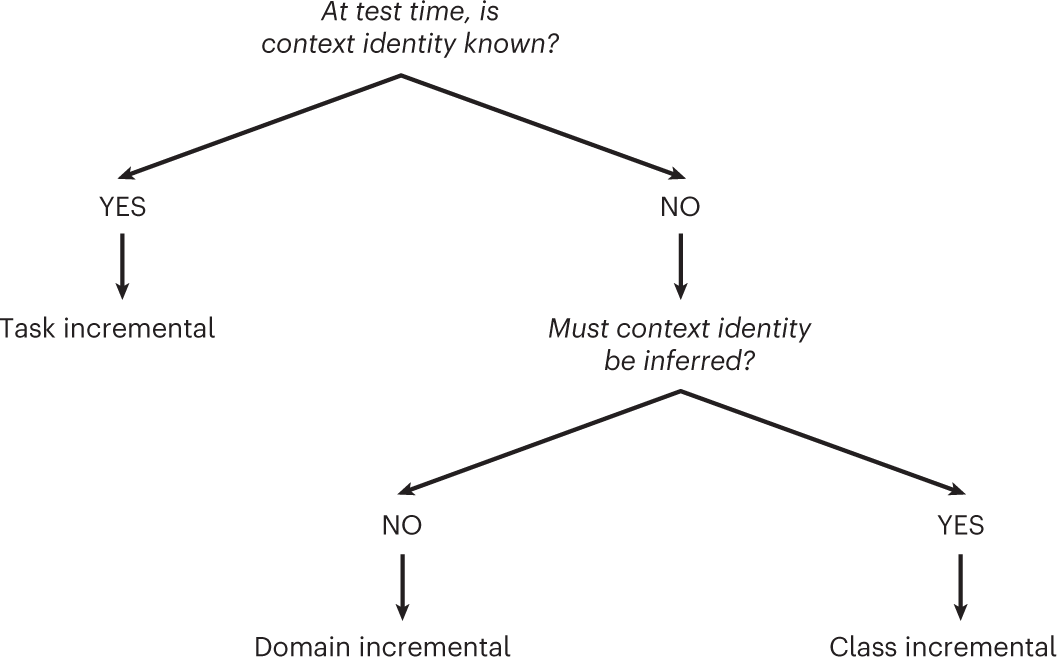

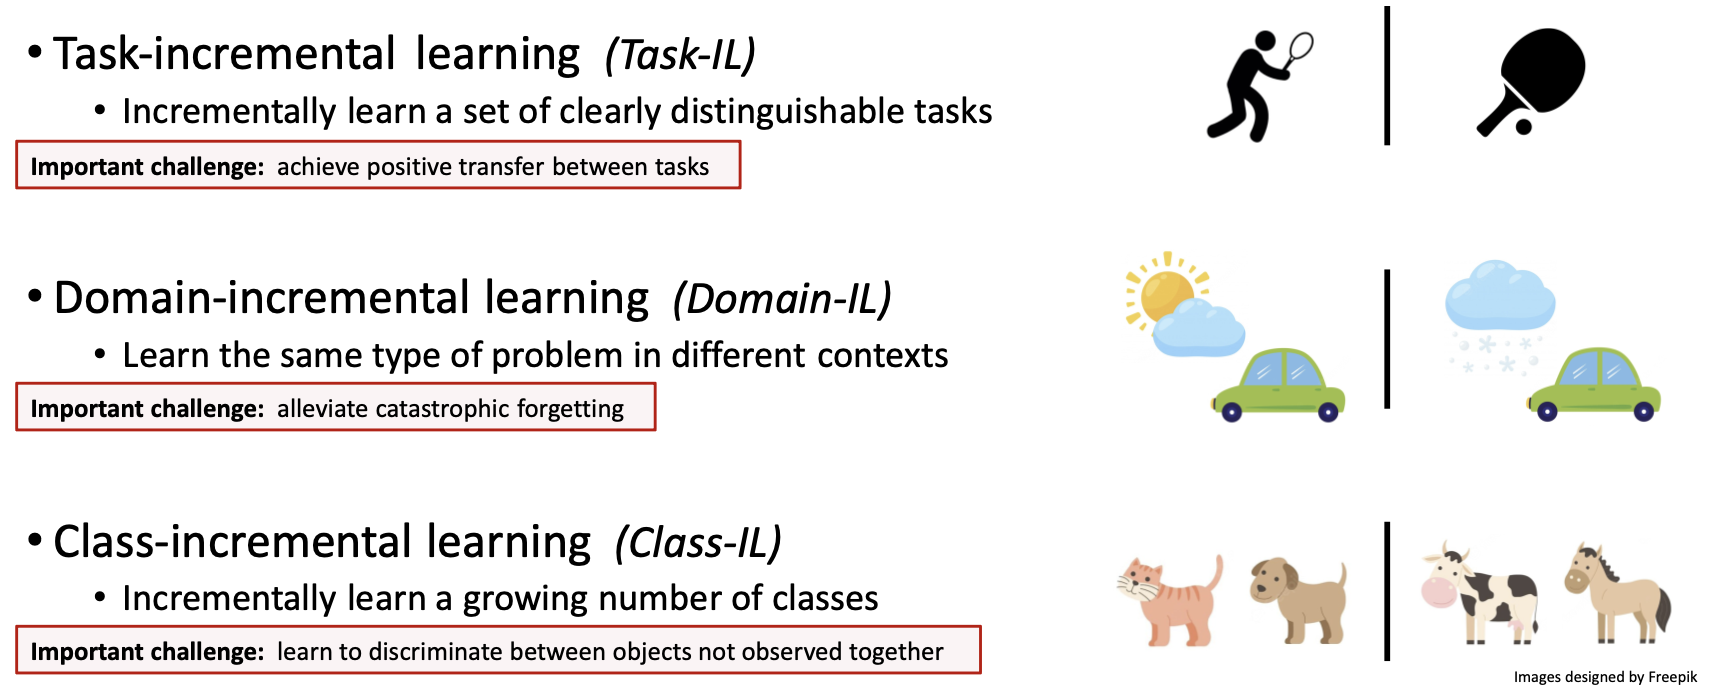

### ASSIGNMENT: What scenario was used for Permuted MNIST?

What type of 'scenario' was the permuted MNIST problem that we explored above? Was it task-incremental, domain-incremental or class-incremental? Try to motivate your answer.

In [ ]:
#@title Possible Answer

'''
The Permuted MNIST problem consisted of two contexts: normal MNIST (context 1) and MNIST
with permuted input images (context 2).

After learning both contexts, when the model was evaluated, the model was not told to
which context an image belongs (i.e., the model was not told whether the image to be
classified was permuted or not), but the model also did not need to identify to
which context an image belongs (i.e., the model did not need to predict whether
the image to be classified had permuted pixels or not; it only needed to predict
the original digit displayed in the image).
This thus means that the above Permuted MNIST problem was an example of a domain-incremental
learning problem.

Another way to motivate that this problem is an example of domain-incremental
learning, is to say that in both context 1 (normal MNIST) and context 2 (MNIST with
permuted input images), the 'type of problem' is the same (i.e., to identify the
digit displayed in the original image), but the 'domain' or 'context' is changing (i.e.,
the order/permutation in which the image pixels are presented).
''';

Now let's explore a **class-incremental learning** problem. For this we will no longer use Permuted MNIST (because it is a bit unintuitive to perform Permuted MNIST according to the class-incremental learning scenario), but we will use Split MNIST, which was introduced in the lecture.

### Set up the benchmark (Split MNIST)
We will split the MNIST dataset up in five contexts with two different classes per context.

In [ ]:
contexts = 5
classes_per_context = 2
# Generate labels-per-context
labels_per_context = [
    list(np.array(range(classes_per_context))+classes_per_context*context_id) for context_id in range(contexts)
]
# Split the train and test datasets up into sub-datasets, one for each context
train_datasets = []
test_datasets = []
for labels in labels_per_context:
    train_datasets.append(SubDataset(MNIST_trainset, labels))
    test_datasets.append(SubDataset(MNIST_testset, labels))

In [ ]:
# Visualize the contexts
figure, axis = plt.subplots(1, contexts, figsize=(3*contexts, 4))

for context_id in range(len(train_datasets)):
    plot_examples(axis[context_id], train_datasets[context_id], context_id=context_id)

### Set up the model
We use the same network architecture as before.

In [ ]:
# Specify the architectural layout of the network to use
fc_lay = 4        #--> number of fully-connected layers
fc_units = 40     #--> number of units in each hidden layer
fc_nl = "relu"    #--> what non-linearity to use?

In [ ]:
# Define the model
model = Classifier(image_size=config['size'], image_channels=config['channels'],
                   output_units=config['classes'],
                   fc_layers=fc_lay, fc_units=fc_units, fc_nl=fc_nl)

### Prepare for evaluation throughout training
Below we will use the same continual learning strategies as before (fine-tuning, EWC and replay) to train models on the five contexts of Split MNIST. When we do this, we want to keep track of the performance of the model while it is sequentially trained on these different contexts. For that we will define some functions here.

As is common in the continual learning literature, we will evaluate the performance of the model only after finishing training on each new task. (But see [this paper](https://openreview.net/forum?id=Zy350cRstc6) for an interesting phenomenon that can be observed if we would evaluate the model on previous tasks after each training iteration on the new task.)

In [ ]:
# Define a function to initiate a dict-object in which performance throughout training is logged.
def initiate_result_dict(n_contexts):
    '''Initiate <dict> with accuracy-measures to keep track of.'''
    result_dict = {}
    result_dict["acc per context"] = {}
    for i in range(n_contexts):
        result_dict["acc per context"]["context {}".format(i+1)] = []
    result_dict["average_contexts_so_far"] = []  # average accuracy over all contexts so far
    result_dict["average_all_contexts"] = []     # average accuracy over all contexts
    result_dict["context"] = []                  # number of contexts so far
    return result_dict

In [ ]:
def test_all(model, datasets, current_context, test_size=None, result_dict=None, verbose=False):
    '''Evaluate accuracy of a classifier (=[model]) on all contexts in [datasets].'''

    n_contexts = len(datasets)

    # Evaluate accuracy of model on all contexts
    precs = []
    for i in range(n_contexts):
        precs.append(test_acc(model, datasets[i], test_size=test_size))

    # Compute average accuracy both for all contexts seen so far, and for all contexts
    ave_so_far = sum([precs[context_id] for context_id in range(current_context)]) / current_context
    ave_all = sum([precs[context_id] for context_id in range(n_contexts)]) / n_contexts

    # Print results on screen
    if verbose:
        print(' => ave accuracy (contexts so far): {:.3f}'.format(ave_so_far))
        print(' => ave accuracy (all contexts):    {:.3f}'.format(ave_all))

    # Add results to [result_dict]
    if result_dict is not None:
        for i in range(n_contexts):
            result_dict['acc per context']['context {}'.format(i+1)].append(precs[i])
        result_dict['average_all_contexts'].append(ave_all)
        result_dict['average_contexts_so_far'].append(ave_so_far)
        result_dict['context'].append(current_context)

### Compare fine-tuning, EWC and experience replay on Split MNIST

#### Fine-tuning

In [ ]:
# Create a copy from the base-model
model_finetune = copy.deepcopy(model)

In [ ]:
# Initiate a `results_dict` to keep track of performance throughout the continual training.
result_dict_finetune = initiate_result_dict(contexts)

For fine-tuning, we can simply re-use the `train`-function we had defined above to train the model on a given dataset in "the standard way" (i.e., without using any specific continual learning strategy).

In [ ]:
# Sequentially train the model on all contexts using finetuning
for context_id in range(contexts):
    # train the model on this context
    train(model_finetune, dataset=train_datasets[context_id], iters=iters, lr=lr,
          batch_size=batch_size)
    # evaluate the performance of the model after training on this context
    test_all(model_finetune, test_datasets, context_id+1, test_size=None,
             result_dict=result_dict_finetune, verbose=True)

In [ ]:
#@title Visualization function
def plot_lines(list_with_lines, x_axes=None, line_names=None, colors=None, title=None,
               title_top=None, xlabel=None, ylabel=None, ylim=None, figsize=None, list_with_errors=None, errors="shaded",
               x_log=False, with_dots=False, linestyle='solid', h_line=None, h_label=None, h_error=None,
               h_lines=None, h_colors=None, h_labels=None, h_errors=None):
    '''Generates a figure containing multiple lines in one plot.

    :param list_with_lines: <list> of all lines to plot (with each line being a <list> as well)
    :param x_axes:          <list> containing the values for the x-axis
    :param line_names:      <list> containing the names of each line
    :param colors:          <list> containing the colors of each line
    :param title:           <str> title of plot
    :param title_top:       <str> text to appear on top of the title
    :return: f:             <figure>
    '''

    # if needed, generate default x-axis
    if x_axes == None:
        n_obs = len(list_with_lines[0])
        x_axes = list(range(n_obs))

    # if needed, generate default line-names
    if line_names == None:
        n_lines = len(list_with_lines)
        line_names = ["line " + str(line_id) for line_id in range(n_lines)]

    # make plot
    size = (12,7) if figsize is None else figsize
    f, axarr = plt.subplots(1, 1, figsize=size)

    # add error-lines / shaded areas
    if list_with_errors is not None:
        for line_id, name in enumerate(line_names):
            if errors=="shaded":
                axarr.fill_between(x_axes, list(np.array(list_with_lines[line_id]) + np.array(list_with_errors[line_id])),
                                   list(np.array(list_with_lines[line_id]) - np.array(list_with_errors[line_id])),
                                   color=None if (colors is None) else colors[line_id], alpha=0.25)
            else:
                axarr.plot(x_axes, list(np.array(list_with_lines[line_id]) + np.array(list_with_errors[line_id])), label=None,
                           color=None if (colors is None) else colors[line_id], linewidth=1, linestyle='dashed')
                axarr.plot(x_axes, list(np.array(list_with_lines[line_id]) - np.array(list_with_errors[line_id])), label=None,
                           color=None if (colors is None) else colors[line_id], linewidth=1, linestyle='dashed')

    # mean lines
    for line_id, name in enumerate(line_names):
        axarr.plot(x_axes, list_with_lines[line_id], label=name,
                   color=None if (colors is None) else colors[line_id],
                   linewidth=4, marker='o' if with_dots else None, linestyle=linestyle if type(linestyle)==str else linestyle[line_id])

    # add horizontal line
    if h_line is not None:
        axarr.axhline(y=h_line, label=h_label, color="grey")
        if h_error is not None:
            if errors == "shaded":
                axarr.fill_between([x_axes[0], x_axes[-1]],
                                   [h_line + h_error, h_line + h_error], [h_line - h_error, h_line - h_error],
                                   color="grey", alpha=0.25)
            else:
                axarr.axhline(y=h_line + h_error, label=None, color="grey", linewidth=1, linestyle='dashed')
                axarr.axhline(y=h_line - h_error, label=None, color="grey", linewidth=1, linestyle='dashed')

    # add horizontal lines
    if h_lines is not None:
        h_colors = colors if h_colors is None else h_colors
        for line_id, new_h_line in enumerate(h_lines):
            axarr.axhline(y=new_h_line, label=None if h_labels is None else h_labels[line_id],
                          color=None if (h_colors is None) else h_colors[line_id])
            if h_errors is not None:
                if errors == "shaded":
                    axarr.fill_between([x_axes[0], x_axes[-1]],
                                       [new_h_line + h_errors[line_id], new_h_line+h_errors[line_id]],
                                       [new_h_line - h_errors[line_id], new_h_line - h_errors[line_id]],
                                       color=None if (h_colors is None) else h_colors[line_id], alpha=0.25)
                else:
                    axarr.axhline(y=new_h_line+h_errors[line_id], label=None,
                                  color=None if (h_colors is None) else h_colors[line_id], linewidth=1,
                                  linestyle='dashed')
                    axarr.axhline(y=new_h_line-h_errors[line_id], label=None,
                                  color=None if (h_colors is None) else h_colors[line_id], linewidth=1,
                                  linestyle='dashed')

    # finish layout
    # -set y-axis
    if ylim is not None:
        axarr.set_ylim(ylim)
    # -add axis-labels
    if xlabel is not None:
        axarr.set_xlabel(xlabel)
    if ylabel is not None:
        axarr.set_ylabel(ylabel)
    # -add title(s)
    if title is not None:
        axarr.set_title(title)
    if title_top is not None:
        f.suptitle(title_top)
    # -add legend
    if line_names is not None:
        axarr.legend()
    # -set x-axis to log-scale
    if x_log:
        axarr.set_xscale('log')

    # return the figure
    return f

In [ ]:
# Visualize performance on each context throughout the continual training
plot_list = []
for i in range(contexts):
    plot_list.append(result_dict_finetune["acc per context"]["context {}".format(i + 1)])
figure = plot_lines(
    plot_list, x_axes=result_dict_finetune["context"],
    line_names=['context {}'.format(i + 1) for i in range(contexts)],
    title="Fine-tuning", ylabel="Test Accuracy (%)",
    xlabel="Number of contexts trained so far", figsize=(10,5),
)

That doesn't look great! The performance on data from each context drops to zero as soon as the next context has been learned.

Can this be fixed with EWC or replay?



#### EWC

In [ ]:
# Create a copy from the base-model
model_ewc = copy.deepcopy(model)

In [ ]:
# Initiate a `results_dict` to keep track of performance throughout the continual training.
result_dict_ewc = initiate_result_dict(contexts)

In [ ]:
# Select a hyperparameter for EWC
ewc_lambda = 100

In [ ]:
# Sequentially train the model on all contexts using EWC
for context_id in range(contexts):
    # Train the model on this context
    train_ewc(model_ewc, train_datasets[context_id], iters=iters, lr=lr, batch_size=batch_size,
              current_context=context_id+1, ewc_lambda=ewc_lambda)
    # Estimate/update the FI-matrix (which is stored as attribute in the network)
    estimate_fisher(model_ewc, train_datasets[context_id], n_samples=200)
    # Evaluate the performance of the model after training on this context
    test_all(model_ewc, test_datasets, context_id+1, test_size=None,
             result_dict=result_dict_ewc, verbose=True)

In [ ]:
# Visualize performance on each context throughout the continual training
plot_list = []
for i in range(contexts):
    plot_list.append(result_dict_ewc["acc per context"]["context {}".format(i + 1)])
figure = plot_lines(
    plot_list, x_axes=result_dict_ewc["context"],
    line_names=['context {}'.format(i + 1) for i in range(contexts)],
    title="EWC", ylabel="Test Accuracy (%)",
    xlabel="Number of contexts trained so far", figsize=(10,5),
)

On this problem, EWC does not seem to help!

#### Experience Replay

In [ ]:
# Create a copy from the base-model
model_replay = copy.deepcopy(model)

In [ ]:
# Initiate a `results_dict` to keep track of performance throughout the continual training.
result_dict_replay = initiate_result_dict(contexts)

In [ ]:
# Select how many samples per class can be stored in the memory buffer
buffer_size_per_class = 20

In [ ]:
# Sequentially train the model on all contexts using Experience Replay
memory_sets = []
buffer_dataset = None
for context_id in range(contexts):
    # Train the model on this context
    train_replay(model_replay, train_datasets[context_id], iters=iters, lr=lr,
                 batch_size=batch_size, current_context=context_id+1, buffer_dataset=buffer_dataset)
    # Update memory buffer
    classes_in_this_context = list(range(classes_per_context*context_id,
                                         classes_per_context*(context_id+1)))
    memory_sets = fill_memory_buffer(memory_sets, train_datasets[context_id],
                                     buffer_size_per_class=buffer_size_per_class,
                                     class_indeces=classes_in_this_context)
    buffer_dataset = MemorySetDataset(memory_sets)
    # Evaluate the performance of the model after training on this context
    test_all(model_replay, test_datasets, context_id+1, test_size=None,
             result_dict=result_dict_replay, verbose=True)

In [ ]:
# Visualize performance on each context throughout the continual training
plot_list = []
for i in range(contexts):
    plot_list.append(result_dict_replay["acc per context"]["context {}".format(i + 1)])
figure = plot_lines(
    plot_list, x_axes=result_dict_replay["context"],
    line_names=['context {}'.format(i + 1) for i in range(contexts)],
    title="Experience Replay ({} samples per class)".format(buffer_size_per_class),
    ylabel="Test Accuracy (%)", xlabel="Number of contexts trained so far", figsize=(10,5),
)

Experience replay does help on this type of continual learning problem!

#### Visual comparison fine-tuning, EWC and replay

In [ ]:
key = "average_contexts_so_far"
plot_list = [result_dict_finetune[key], result_dict_ewc[key], result_dict_replay[key]]
line_names = ['Fine-tuning', 'EWC', 'Experience Replay']
figure = plot_lines(
    plot_list, x_axes=result_dict_replay["context"], line_names=line_names,
    title="Comparison (performance on all contexts so far)",
    ylabel="Test Accuracy (%)", xlabel="Number of contexts trained so far", figsize=(10,5),
)

In [ ]:
key = "average_all_contexts"
plot_list = [result_dict_finetune[key], result_dict_ewc[key], result_dict_replay[key]]
line_names = ['Fine-tuning', 'EWC', 'Experience Replay']
figure = plot_lines(
    plot_list, x_axes=result_dict_replay["context"], line_names=line_names,
    title="Comparison (performance on all contexts)",
    ylabel="Test Accuracy (%)", xlabel="Number of contexts trained so far", figsize=(10,5),
)

(Note that the lines of `fine-tuning` and `EWC` might well overlap almost completely.)

### **ASSIGNMENT**: Combine EWC and replay on class-incremental Split MNIST
Train another model copy on the class-incremental version of Split MNIST, now again using *both* EWC and experience replay.

In [ ]:
model_ewc_replay = copy.deepcopy(model)
result_dict_ewc_replay = initiate_result_dict(contexts)

In [ ]:
# TO BE COMPLETED

In [ ]:
#@title Possible Answer

# Select hyperparameter for EWC
ewc_lambda_with_replay = 100

# Sequentially train the model on all contexts using both EWC and Experience Replay
memory_sets = []
buffer_dataset = None
for context_id in range(contexts):

    # Train the model on this context
    train_ewc_replay(model_ewc_replay, train_datasets[context_id], iters=iters, lr=lr,
                     batch_size=batch_size, current_context=context_id+1,
                     ewc_lambda=ewc_lambda_with_replay, buffer_dataset=buffer_dataset)
    # NOTE: depending on how you had written your `train_ewc_replay` function, you might need to
    #       adjust it to make it suitable for the more general case in which the function is used
    #       for arbitrary contexts

    # Estimate/update the FI-matrix (which is stored as attribute in the network)
    estimate_fisher(model_ewc_replay, train_datasets[context_id], n_samples=200)

    # Update memory buffer
    classes_in_this_context = list(range(classes_per_context*context_id,
                                         classes_per_context*(context_id+1)))
    memory_sets = fill_memory_buffer(memory_sets, train_datasets[context_id],
                                     buffer_size_per_class=buffer_size_per_class,
                                     class_indeces=classes_in_this_context)
    buffer_dataset = MemorySetDataset(memory_sets)

    # Evaluate the performance of the model after training on this context
    test_all(model_ewc_replay, test_datasets, context_id+1, test_size=None,
             result_dict=result_dict_ewc_replay, verbose=True)

In [ ]:
# Visualize performance on each context throughout the continual training
plot_list = []
for i in range(contexts):
    plot_list.append(result_dict_ewc_replay["acc per context"]["context {}".format(i + 1)])
figure = plot_lines(
    plot_list, x_axes=result_dict_ewc_replay["context"],
    line_names=['context {}'.format(i + 1) for i in range(contexts)],
    title="EWC + Experience Replay ({} samples per class)".format(buffer_size_per_class),
    ylabel="Test Accuracy (%)", xlabel="Number of contexts trained so far", figsize=(10,5),
)

Is there a benefit of "EWC + Experience Replay" over only "Experience Replay"? Let's compare them more directly.

In [ ]:
key = "average_contexts_so_far"
plot_list = [result_dict_finetune[key], result_dict_ewc[key], result_dict_replay[key],
             result_dict_ewc_replay[key]]
line_names = ['Fine-tuning', 'EWC', 'Experience Replay', 'EWC + Experience Replay']
figure = plot_lines(
    plot_list, x_axes=result_dict_replay["context"], line_names=line_names,
    title="Comparison (performance on all contexts so far)",
    ylabel="Test Accuracy (%)", xlabel="Number of contexts trained so far", figsize=(10,5),
)

## Bonus Part: Task- and domain-incremental learning version of Split MNIST
As a *bonus exercise*, let's try to think about how to adapt the code above such that we can run the same experiment, except that we perform Split MNIST according to the task- and domain-incremental learning scenarios rather than the class-incremental learning scenario.

Recall from the lecture that Split MNIST (just like any other sequence of classification tasks), can be performed according to each of the three scenarios:

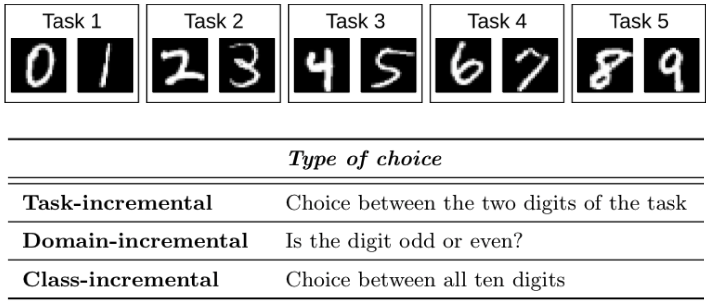



### Domain-incremental Split MNIST
To create the domain-incrmental learning version of Split MNIST, the number of possible output classes needs to be changed from ten (one output class for each digit) to two (one output class for `odd` and one output class for `even`).

To implement this, we need to change both the way the benchmark is defined (e.g., in the second context, the digits '2' and '3' should no longer be labelled with `y=2` and `y=3`, but instead with `y=0` and `y=1`), and we need to change the way the classifier is defined (as it should now have two output units rather than ten).

### Task-incremental Split MNIST
To create the task-incremental version of Split MNIST, the context label needs to be provided as input to the model. Usually, this context label will then be used to enable a "multi-headed output layer", meaning that there is a separate output layer per task.

One option to implement this is to keep the number of output classes at ten and to still have the same, single output layer as in the class-incremental learning case, but to always mask out the outputs that are not in the current context.

Another option to implement this is to set the number of output classes to two (as in the domain-incremental learning case) and to define a separate output layer per task.



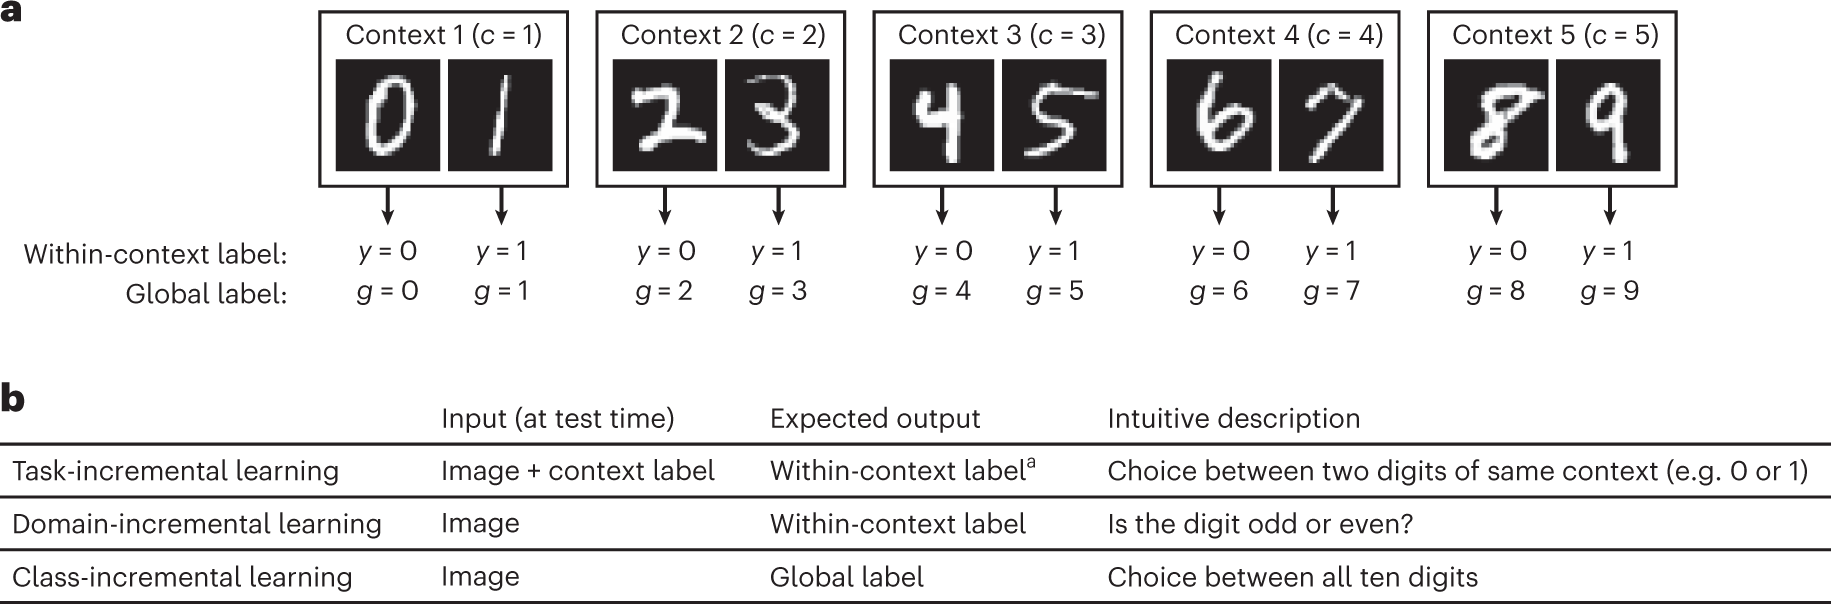

$^{\text{a}}$ With task-incremental learning, at the computational level, there is no difference between whether the algorithm must return the within-context label or the global label, because the within-context label can be combined with the context label (which is provided as input) to get the global label.